In [36]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

#Scaling:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Outlier handling
from feature_engine.outliers import Winsorizer

#Building clustering model
from sklearn.cluster import KMeans 

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

# Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

In [4]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [6]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRA

In [7]:
#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])
remove_dup.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"

# Add RFM column

In [8]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = remove_dup.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = remove_dup.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = remove_dup.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

In [9]:
RFM_table_df=RFM_table.to_pandas()

In [10]:
RFM_table_df=RFM_table_df.drop('ORDER_TS',axis=1,errors='ignore')

In [11]:
RFM_table_df.head()

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY
0,118147,27,53,2072.25
1,215145,2,63,2891.00
2,27655,2,67,3052.50
3,54944,5,54,1947.25
4,8323,5,51,2019.00


# Data Transformation

In [39]:
X = RFM_table_df.drop("CUSTOMER_ID", axis=1)

## Outlier Handling
<b>Outlier handling increased the models inertia/SSE, therefore it is in markdown.

#create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','FREQUENCY','MONETARY'])

windsorizer.fit(X)

X_win = windsorizer.transform(X)

## Scaling

In [40]:
# Scaling the data so that all the features/attributes become comparable 
MinMax = MinMaxScaler()
X_scaled_MinMax=MinMax.fit_transform(X)

Standard= StandardScaler()
X_scaled_Standard=Standard.fit_transform(X)

# K Means Clustering

In [41]:
#Build kmeans for standard scaled data
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_Standard)

KMeans(n_clusters=3, n_init=20, random_state=1)

In [42]:
# Evalute the model using Sum of Squared Errors (SSE) : Standard Scaler
kmeans.inertia_

300288.0309541513

In [43]:
#Build kmeans for min max scaled data
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

KMeans(n_clusters=3, n_init=20, random_state=1)

In [44]:
# Evalute the model using Sum of Squared Errors (SSE) : Min Max
kmeans.inertia_

2859.3110351915902

As you can see, the Sum of Squared Errors for the kmeans built on the min max scaler is much lower compared to that of the kmeans built on the standard scaler. Therefore, we will be working on the min max scaled data.

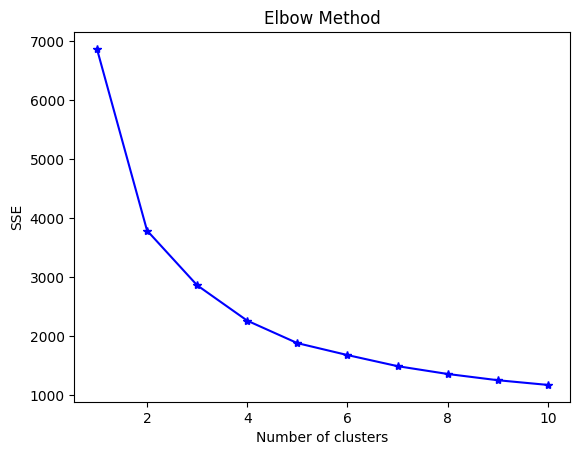

In [45]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled_MinMax)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [46]:
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

1878.8259647423356

RECENCY


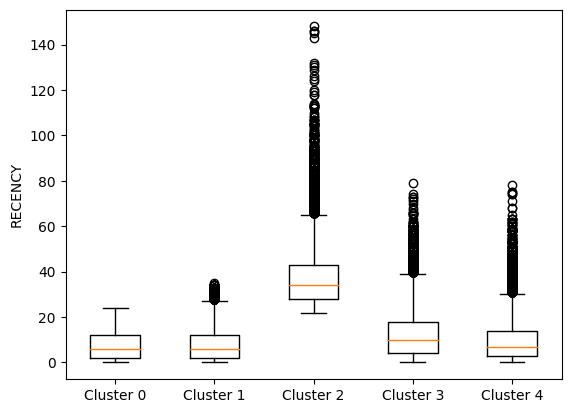

FREQUENCY


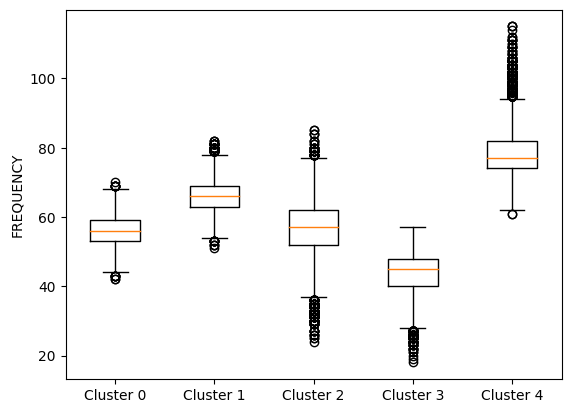

MONETARY


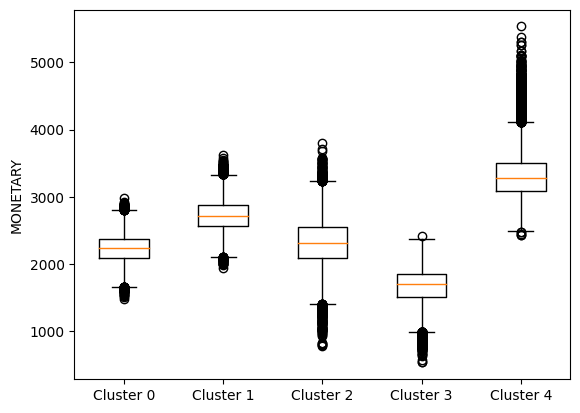

In [47]:
y_pred = kmeans.fit_predict(X_scaled_MinMax)

X['Cluster']=y_pred

i=0
for col in X.drop('Cluster',axis=1): 
    print(col) 
    plt.cla()
    plt.boxplot([X.iloc[:,i][X.Cluster==0].tolist(),
                 X.iloc[:,i][X.Cluster==1].tolist(),
                 X.iloc[:,i][X.Cluster==2].tolist(),
                 X.iloc[:,i][X.Cluster==3].tolist(),
                X.iloc[:,i][X.Cluster==4].tolist()],
                 labels=('Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'))    
    plt.ylabel(col)
    plt.show()
    i=i+1

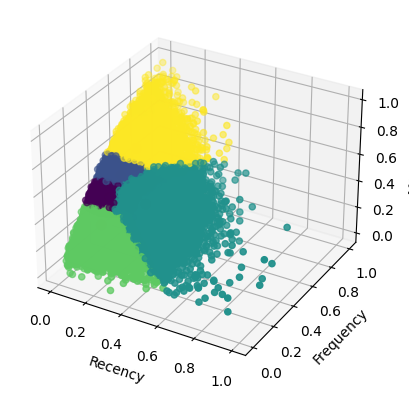

In [48]:
fig = plt.figure(20)
ax = plt.axes(projection='3d')
ax.scatter3D(X_scaled_MinMax[:,0], X_scaled_MinMax[:,1], X_scaled_MinMax[:,2], c=y_pred);
ax.scatter3D(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s=50, c='red')


ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

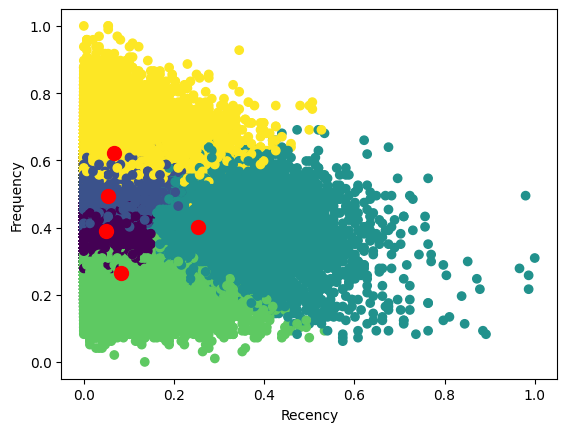

In [49]:
plt.scatter(X_scaled_MinMax[:,0], X_scaled_MinMax[:,1], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

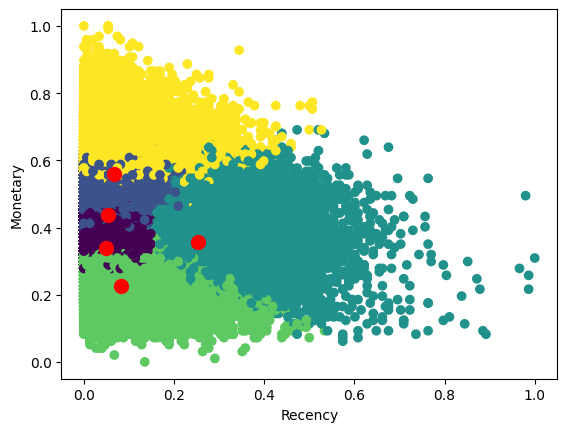

In [50]:
plt.scatter(X_scaled_MinMax[:,0], X_scaled_MinMax[:,1], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=100, c='red')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

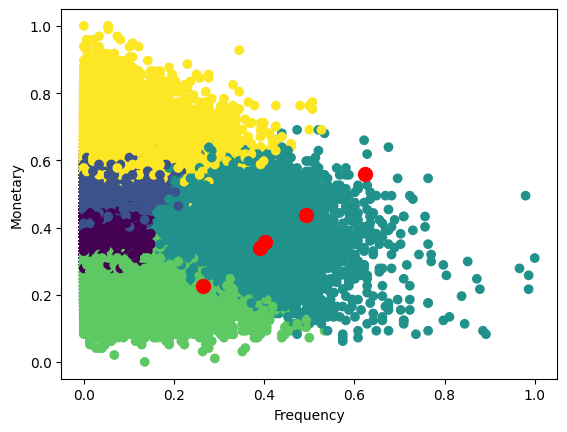

In [51]:
plt.scatter(X_scaled_MinMax[:,0], X_scaled_MinMax[:,1], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=100, c='red')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()